### Notebook to genereate plots of isentropic binned variables.

James Ruppert  
jruppert@ou.edu  
5/10/24

In [1]:
# NOTE: Using copied tracking from CTL for NCRF tests

import numpy as np
from matplotlib import rc
from matplotlib import colors, ticker
import matplotlib.pyplot as plt
from read_functions import *
from thermo_functions import *

### Main settings

In [2]:
storm = 'haiyan'
# storm = 'maria'

# Set to true to do sensitivty test comparisons
# Else: analysis of CTL only
do_tests=True
# do_tests=False
t1_test=12 # n time steps to sample for tests

# Set to true to use vertical hi-res data
do_hires=True
# do_hires=False

main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
datdir2 = 'post/d02/'

# pclass_names = ['all','noncloud','shallowc','congest','deepc','strat','anvil']
# pclass_title=["All", "Non-cloud", "Shallow", "Cong", "Deep", "Strat", "Anvil"]
pclass_names = ['all','shallowc','congest','deepc','strat','anvil']
pclass_title=["All", "Shallow", "Cong", "Deep", "Strat", "Anvil"]
# pclass_names = ['all','mcs','congest','deepc','strat','anvil']
# pclass_title=["All", "MCS", "Cong", "Deep", "Strat", "Anvil"]
npclass = len(pclass_names)

# Tests to read and compare
if storm == 'haiyan':
    tests = ['ctl','ncrf36h','STRATANVIL_ON','STRATANVIL_OFF','STRAT_OFF']
    tests_str = ['CTL','NCRF','STRATANVON','STRATANVOFF','STRATOFF']
    # tests = ['ctl','ncrf36h']
    # tests_str = ['CTL','NCRF']
    # tests = ['crfon','ncrf']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']
    tests_str = ['CTL','NCRF']

# if not do_tests:
#     tests = [tests[0]]
#     tests_str = [tests_str[0]]

time_neglect=12 # time steps from start to neglect
# This only applies for CTL when not comparing tests

# Shift starting-read time step for CRFON comparison
t0_test=0
# if 'crfon' in tests[1]:
#     t0_test=24 # CRFON is restarted at t=24 in NCRF
    # memb0=5 # for CRFFON test

# Members
nmem = 10 # number of ensemble members
enstag = str(nmem)

### Read functions

In [3]:
# Theta-e (equivalent potential temperature) bins
fmin=305; fmax=365 # K
nbins = 70
bins=np.linspace(fmin,fmax,num=nbins)

# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
nt=nt_data-time_neglect
if do_hires:
    pres = np.arange(1000,25,-25)
nz = pres.size

In [4]:
################################################
#### NetCDF variable metadata

def var_regrid_metadata(nt,nz,nbins):

    nbinsm1 = nbins-1

    var_names = [
        'bins',
        'pres',
        'theta_e_mn',
        'frequency',
        'tmpk',
        'qv',
        'rho',
        # 'h_diabatic',
        'lw',
        'lwc',
        'sw',
        'swc',
        'w',
        'theta_v_prm',
        'tmpk_mean',
        'qv_mean',
        'rho_mean',
        'lw_mean',
        'lwc_mean',
        'sw_mean',
        'swc_mean',
        'w_mean',
    ]
    descriptions = [
        'equivalent potential temperature bins',
        'pressure',
        'mean equivalent potential temperature',
        'frequency',
        'temperature',
        'water vapor mixing ratio',
        'density',
        # 'H_DIABATIC',
        'LW heat tendency',
        'LW clear-sky heat tendency',
        'SW heat tendency',
        'SW clear-sky heat tendency',
        'vertical motion',
        'virtual potential temperature xy-anomaly',
        'mean temperature',
        'mean water vapor mixing ratio',
        'mean density',
        'mean LW heat tendency',
        'mean LW clear-sky heat tendency',
        'mean SW heat tendency',
        'mean SW clear-sky heat tendency',
        'mean vertical motion',
    ]
    units = [
        'K',
        'hPa',
        'K',
        'n-cells',
        'K',
        'kg/kg',
        'kg/m^3',
        # 'K/s',
        'K/s',
        'K/s',
        'K/s',
        'K/s',
        'm/s',
        'K',
        'K',
        'kg/kg',
        'kg/m^3',
        'K/s',
        'K/s',
        'K/s',
        'K/s',
        'm/s',
    ]
    dims_all = (nt,nz,nbinsm1)
    dim_names = ('nt','nz','nbinsm1')
    dims_set = [
        [('nbins',),(nbins,)],
        [('nz',),(nz,)],
        [('nt','nz'),(nt,nz)],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [('nt','nz'),(nt,nz)],
        [('nt','nz'),(nt,nz)],
        [('nt','nz'),(nt,nz)],
        [('nt','nz'),(nt,nz)],
        [('nt','nz'),(nt,nz)],
        [('nt','nz'),(nt,nz)],
        [('nt','nz'),(nt,nz)],
        [('nt','nz'),(nt,nz)],
    ]

    len1=len(var_names); len2=len(descriptions); len3=len(units); len4=len(dims_set) #len4=len(dim_names)
    if (len1 != len2) or (len1 != len3) or (len1 != len4):
        raise ValueError("Variable info counts are off")

    return var_names, descriptions, units, dims_set

# Variable info
var_names, descriptions, units, dims_set = var_regrid_metadata(nt,nz,nbins)

In [5]:
# Main read loops for 3D (dependent) variables

if do_hires:
    file_tag = '_HiRes.nc'
else:
    file_tag = '.nc'

ntest=len(tests)

ntest_read=ntest
if not do_tests:
    ntest_read=1

allvars_tests = []

# for itest in range(ntest_read):
for test_str in tests[0:ntest_read]:

    # test_str=tests[itest]
    print('Running test: ',test_str)

    if test_str == 'ctl':
        t0=time_neglect
        t1=nt+t0
        if do_tests:
            t0=36
            # t1=t0+49
            # Control test time sample
            t1=t0+t1_test
    else:
        t0=0
        # t1=49 # max
        # Control test time sample
        t1=t1_test

    # Loop over ensemble members

    itest_ens = []
    for imemb in range(nmem):
        print('Running member: ',memb_all[imemb])
        datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
        imemb_allclass = []
        for ipclass in range(npclass):
            pclass_tag = pclass_names[ipclass]
            isentrop_file = datdir+'binned_isentrop_'+pclass_tag+file_tag
            ncfile = Dataset(isentrop_file)
            vars_ipclass = []
            for ivar in var_names:
                vars_ipclass.append(ncfile.variables[ivar][t0:t1,...])
            ncfile.close()
            imemb_allclass.append(vars_ipclass)
        itest_ens.append(imemb_allclass)

    allvars_tests.append(itest_ens)

# Reorganize into a dictionary nested by variable at the top-level

allvars = {}
for ivar in range(len(var_names)):
    ivar_alltests = []
    for itest in range(ntest_read):
        test_str = tests[itest]
        itest_ens = []
        for imemb in range(nmem):
            imemb_allpclass = []
            for ipclass in range(npclass):
                imemb_allpclass.append(allvars_tests[itest][imemb][ipclass][ivar])
            itest_ens.append(imemb_allpclass)
        ivar_alltests.append(itest_ens)
    allvars[var_names[ivar]] = ivar_alltests

# for key, value in allvars['ctl']['memb_03']['all'].items():
#     print(key)

Running test:  ctl
Running member:  memb_01
Running member:  memb_02
Running member:  memb_03
Running member:  memb_04
Running member:  memb_05
Running member:  memb_06
Running member:  memb_07
Running member:  memb_08
Running member:  memb_09
Running member:  memb_10
Running test:  ncrf36h
Running member:  memb_01
Running member:  memb_02
Running member:  memb_03
Running member:  memb_04
Running member:  memb_05
Running member:  memb_06
Running member:  memb_07
Running member:  memb_08
Running member:  memb_09
Running member:  memb_10
Running test:  STRATANVIL_ON
Running member:  memb_01
Running member:  memb_02
Running member:  memb_03
Running member:  memb_04
Running member:  memb_05
Running member:  memb_06
Running member:  memb_07
Running member:  memb_08
Running member:  memb_09
Running member:  memb_10
Running test:  STRATANVIL_OFF
Running member:  memb_01
Running member:  memb_02
Running member:  memb_03
Running member:  memb_04
Running member:  memb_05
Running member:  memb_06

### Plot functions

In [6]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

#### Main plot code

In [7]:
def plot_pclass_multipan(bins, pres, invar, th_mean, title_tag, units, pclass_title,
                    cmap='RdGy_r', norm=None, th_mean0=None, do_thm0_pclass=False, invar_mean=None):

# Now plotting mean panels side-by-side

        if invar_mean is None:
                do_means=False
                npanel=1
        else:
                do_means=True
                npanel=2

        if do_means:
                fig, axs = plt.subplots(2,6, figsize=(14,9), layout="constrained", # row, column
                        width_ratios=[5,2,5,2,5,2])
                axs[1,2].set_xlabel(r'$\theta_e$ [K]')
                axs[0,5].set_title('Mean')
                axs[1,5].set_xlabel(units)
        else:
                fig, axs = plt.subplots(2,3, figsize=(14,9)) # row, column
                axs[1,1].set_xlabel(r'$\theta_e$ [K]')

        fig_title = title_tag
        fig.suptitle(fig_title)

        for irow in range(2):
                axs[irow,0].set_ylabel('Pressure [hPa]')

        # for ipclass in range(npclass):
        for ipclass in range(npclass):
                # if ipclass == 1:
                #         continue
                icol=ipclass
                if icol < 3:
                        irow=0
                else:
                        irow=1
                        icol-=3
                if do_means:
                        icol*=2
                subtitle = pclass_title[ipclass]
                axs[irow,icol].set_title(subtitle)
                for ipan in range(npanel):
                        icol+=ipan
                        axs[irow,icol].set_yscale('log')
                        nz=pres.size
                        dp = pres[0]-pres[1]
                        p2 = np.append(np.array(pres+dp/2), pres[nz-1]-dp/2)
                        axs[irow,icol].set_ylim(1000, 100)
                        axs[irow,icol].yaxis.set_major_formatter(ticker.ScalarFormatter())
                        axs[irow,icol].yaxis.set_minor_formatter(ticker.ScalarFormatter())
                        # Fill plot
                        if ipan == 0:
                                axs[irow,icol].grid(True, axis='x', color='0.55', linewidth=0.5)
                                # axs[irow,icol].grid(True, axis='y', color='0.55', linewidth=0.5, which='both')
                                pltvar = invar[ipclass]
                                im = axs[irow,icol].pcolormesh(bins, p2, pltvar, cmap=cmap, norm=norm)
                                axs[irow,icol].set_xlim(305, 365)
                                # Mean profiles
                                linecol='g'
                                axs[irow,icol].plot(th_mean[ipclass], pres, "-"+linecol)
                                if do_thm0_pclass:
                                        axs[irow,icol].plot(th_mean0[ipclass], pres, "--"+linecol)
                                else:
                                        axs[irow,icol].plot(th_mean[0], pres, "--"+linecol)
                        else:
                                axs[irow,icol].plot(invar_mean[ipclass], pres, '-k', linewidth=1)
                                axs[irow,icol].axvline(color='black', linewidth=0.5)
                                # axs[irow,icol].set_xlim(-0.3, .7)
                        axs[irow,icol].grid(True, axis='y', color='0.55', linewidth=0.5, which='both')
                        # Remove labels for inner panels
                        if icol > 0:
                                yticks = np.arange(1000,0,-100)
                                axs[irow,icol].yaxis.set_ticks(yticks, labels=np.repeat('',yticks.size))
                        # if irow == 0 and ipan == 0:
                        #         xticks = axs[irow,icol].get_xticks()
                        #         axs[irow,icol].xaxis.set_ticks(xticks, labels=np.repeat('',xticks.size))

        # fig.subplots_adjust(right=0.8)
        # cbar_ax = fig.add_axes([0.83, 0.25, 0.02, 0.5]) # L, B, Width, Height
        # fig.colorbar(im, cax=cbar_ax, label=units)
        fig.colorbar(im, ax=axs, label=units, shrink=0.6)

        # plt.tight_layout()
        plt.show()
        plt.close()

In [8]:
# Individual panels
# def plot_binned_var(bins, pres, binvar, th_mean, title_tag, units, pclass_title, test_str,
#                     cmap='RdGy_r', norm=None):
#         for ipclass in range(npclass):
#                 fig_title = title_tag+' ('+pclass_title[ipclass]+'; '+test_str.upper()+')'
#                 # create figure
#                 fig = plt.figure()#figsize=(14,4))
#                 ax = fig.add_subplot(111)
#                 ax.set_title(fig_title)
#                 ax.set_xlabel(r'$\theta_e$ [K]')
#                 ax.set_ylabel('Pressure [hPa]')
#                 ax.set_yscale('log')
#                 nz=pres.size
#                 dp = pres[0]-pres[1]
#                 p2 = np.append(np.array(pres+dp/2), pres[nz-1]-dp/2)
#                 ibinvar = binvar[ipclass]
#                 im = ax.pcolormesh(bins, p2, ibinvar, cmap=cmap, norm=norm)
#                 # Mean profile
#                 plt.plot(th_mean[ipclass], pres, "-k")
#                 plt.plot(th_mean[0], pres, "--k")
#                 plt.xlim(300, 370)
#                 plt.ylim(1000, 100)
#                 ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
#                 ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
#                 cbar = plt.colorbar(im, ax=ax, shrink=0.75)
#                 cbar.ax.set_ylabel(units)
#                 # plt.savefig(figdir+'pclass_frac_'+binvartag+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 #             bbox_inches='tight', pad_inches=0.2)
#                 plt.show()
#                 plt.close()

#### CTL plots

In [9]:
def run_ctl_plots(do_freq=False, do_freqnorm=False, do_relhum=False, do_vmf=False, do_lwcrf=False,
                  do_swcrf=False, do_swrad=False, do_totrad=False, do_thv=False, do_thvprm=False,
                  do_umf=False, do_dmf=False):

    # ktest=0
    for ktest in range(1):

        th_mean = np.array(allvars['theta_e_mn'][ktest])
        frequency = np.array(allvars['frequency'][ktest])

        frequency = np.mean(frequency,axis=(0,2))
        th_mean = np.mean(th_mean,axis=(0,2))

        if do_freq:

            title_tag = 'Frequency ('+tests_str[ktest].upper()+')  '
            units = ' '
            cmap = 'twilight'
            normmin=1
            normmax=1e5
            norm=colors.LogNorm(vmin=normmin, vmax=normmax)
            plot_pclass_multipan(bins, pres, frequency, th_mean, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm)

        if do_freqnorm:

            title_tag = "Normalized Frequency Difference from 'All' ("+tests_str[ktest].upper()+")  "
            units = '%'
            cmap = 'RdGy_r'
            norm=colors.SymLogNorm(linthresh=0.01, linscale=1, vmin=-1e-1, vmax=1e-1)

            ifreq1 = frequency[0]
            freq_norm = np.copy(frequency)
            total1 = np.nansum(ifreq1)
            for ipclass in range(npclass):
                ifreq2 = frequency[ipclass]
                total2 = np.nansum(ifreq2)
                freq_norm[ipclass] = 1e2*((ifreq2/total2) - (ifreq1/total1))# / (ifreq1/total1)

            plot_pclass_multipan(bins, pres, freq_norm, th_mean, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm)

        if do_relhum:

            qv = np.array(allvars['qv'][ktest])
            tmpk = np.array(allvars['tmpk'][ktest])
            qv_mean = np.mean(qv,axis=(0,2))
            tmpk_mean = np.mean(tmpk,axis=(0,2))
            relh = calc_relh(qv_mean, pres[np.newaxis,:,np.newaxis]*1e2, tmpk_mean, ice=True)

            qv_mn = np.array(allvars['qv_mean'][ktest])
            tmpk_mn = np.array(allvars['tmpk_mean'][ktest])
            qv_allmean = np.mean(qv_mn,axis=(0,2))
            tmpk_allmean = np.mean(tmpk_mn,axis=(0,2))
            invar_allmean = calc_relh(qv_allmean, pres[np.newaxis,:]*1e2, tmpk_allmean, ice=True)

            title_tag = 'Relative Humidity ('+tests_str[ktest].upper()+')  '
            units = '%'
            cmap = 'BrBG'
            norm=colors.Normalize(vmin=20, vmax=100)

            plot_pclass_multipan(bins, pres, relh, th_mean, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm, invar_mean=invar_allmean)

        if do_vmf:

            w = np.array(allvars['w'][ktest])
            rho = np.array(allvars['rho'][ktest])
            vmf = w*rho # kg/m2/s
            vmf_mean = np.mean(vmf,axis=(0,2))

            wmean = np.array(allvars['w_mean'][ktest])
            rhomean = np.array(allvars['rho_mean'][ktest])
            invar_allmean = np.mean(wmean*rhomean,axis=(0,2)) # kg/m2/s

            title_tag = 'VMF ('+tests_str[ktest].upper()+')  '
            units = 'kg/m$^2$/s'
            cmap = 'RdGy_r'
            normmin=-1e0; normmax=1e0
            norm = colors.SymLogNorm(linthresh=1e-2, linscale=1, vmin=normmin, vmax=normmax)
            plot_pclass_multipan(bins, pres, vmf_mean, th_mean, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm, invar_mean=invar_allmean)

        if do_umf:

            w = np.array(allvars['w'][ktest])
            rho = np.array(allvars['rho'][ktest])
            vmf = w*rho # kg/m2/s
            umf = np.ma.masked_where(vmf <= 0, vmf, copy=True)
            umf_mean = np.mean(umf,axis=(0,2))

            title_tag = 'UMF ('+tests_str[ktest].upper()+')  '
            units = 'kg/m$^2$/s'
            cmap = 'RdGy_r'
            normmin=-1e0; normmax=1e0
            norm = colors.SymLogNorm(linthresh=1e-2, linscale=1, vmin=normmin, vmax=normmax)
            plot_pclass_multipan(bins, pres, umf_mean, th_mean, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm)#, invar_mean=invar_allmean)

        if do_dmf:

            w = np.array(allvars['w'][ktest])
            rho = np.array(allvars['rho'][ktest])
            vmf = w*rho # kg/m2/s
            dmf = np.ma.masked_where(vmf >= 0, vmf, copy=True)
            dmf_mean = np.mean(dmf,axis=(0,2))*-1 # Flip sign

            title_tag = 'DMF ('+tests_str[ktest].upper()+')  '
            units = 'kg/m$^2$/s'
            cmap = 'RdGy_r'
            normmin=-1e0; normmax=1e0
            norm = colors.SymLogNorm(linthresh=1e-2, linscale=1, vmin=normmin, vmax=normmax)
            plot_pclass_multipan(bins, pres, dmf_mean, th_mean, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm)#, invar_mean=invar_allmean)

        if do_lwcrf:

            lw = np.array(allvars['lw'][ktest])
            lwc = np.array(allvars['lwc'][ktest])
            lwcrf = (lw - lwc)*3600*24 # K/s --> K/d
            lwcrf_mean = np.mean(lwcrf,axis=(0,2))

            lwmean = np.array(allvars['lw_mean'][ktest])
            lwcmean = np.array(allvars['lwc_mean'][ktest])
            lwcrfmean = (lwmean - lwcmean)*3600*24 # K/s --> K/d
            invar_allmean = np.mean(lwcrfmean,axis=(0,2)) # kg/m2/s

            title_tag = 'LW-CRF ('+tests_str[ktest].upper()+')  '
            units = 'K/d'
            cmap = 'RdBu_r'
            norm = colors.TwoSlopeNorm(vmin=-6, vcenter=0, vmax=8)
            plot_pclass_multipan(bins, pres, lwcrf_mean, th_mean, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm, invar_mean=invar_allmean)

        if do_swcrf:

            sw = np.array(allvars['sw'][ktest])
            swc = np.array(allvars['swc'][ktest])
            swcrf = (sw - swc)*3600*24 # K/s --> K/d
            swcrf_mean = np.mean(swcrf,axis=(0,2))

            swmean = np.array(allvars['sw_mean'][ktest])
            swcmean = np.array(allvars['swc_mean'][ktest])
            swcrfmean = (swmean - swcmean)*3600*24 # K/s --> K/d
            invar_allmean = np.mean(swcrfmean,axis=(0,2)) # kg/m2/s

            title_tag = 'SW-CRF ('+tests_str[ktest].upper()+')  '
            units = 'K/d'
            cmap = 'RdBu_r'
            norm = colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=4)
            plot_pclass_multipan(bins, pres, swcrf_mean, th_mean, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm, invar_mean=invar_allmean)

        if do_swrad:

            sw = np.array(allvars['sw'][ktest])
            sw_mean = np.mean(sw,axis=(0,2))*3600*24 # K/s --> K/d

            swmean = np.array(allvars['sw_mean'][ktest])*3600*24 # K/s --> K/d
            invar_allmean = np.mean(swmean,axis=(0,2))

            title_tag = 'SW ('+tests_str[ktest].upper()+')  '
            units = 'K/d'
            cmap = 'RdBu_r'
            norm = colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=4)
            plot_pclass_multipan(bins, pres, sw_mean, th_mean, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm, invar_mean=invar_allmean)

        if do_totrad:

            lw = np.array(allvars['lw'][ktest])*3600*24 # K/s --> K/d
            sw = np.array(allvars['sw'][ktest])*3600*24 # K/s --> K/d
            rad_mean = np.mean(lw+sw,axis=(0,2))

            lwmean = np.array(allvars['lw_mean'][ktest])*3600*24 # K/s --> K/d
            swmean = np.array(allvars['sw_mean'][ktest])*3600*24 # K/s --> K/d
            invar_allmean = np.mean(lwmean+swmean,axis=(0,2))

            title_tag = 'Total Qrad ('+tests_str[ktest].upper()+')  '
            units = 'K/d'
            cmap = 'RdBu_r'
            norm = colors.TwoSlopeNorm(vmin=-4, vcenter=0, vmax=4)
            plot_pclass_multipan(bins, pres, rad_mean, th_mean, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm, invar_mean=invar_allmean)

        if do_thv:

            qv = np.array(allvars['qv'][ktest])
            tmpk = np.array(allvars['tmpk'][ktest])
            qv_mean = np.mean(qv,axis=(0,2))
            tmpk_mean = np.mean(tmpk,axis=(0,2))
            thv_mean = theta_virtual(tmpk_mean, qv_mean, pres[np.newaxis,:,np.newaxis]*1e2) # K

            title_tag = r"$\theta_v$ ("+tests_str[ktest].upper()+')  '
            units = 'K'
            cmap = 'RdBu_r'
            norm = colors.CenteredNorm(halfrange=2)
            plot_pclass_multipan(bins, pres, thv_mean, th_mean, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm, invar_mean=invar_allmean)

        if do_thvprm:

            thvprm = np.array(allvars['theta_v_prm'][ktest])
            thvprm_mean = np.mean(thvprm,axis=(0,2))

            title_tag = r"$\theta_v'$ ("+tests_str[ktest].upper()+')  '
            units = 'K'
            cmap = 'RdBu_r'
            norm = colors.CenteredNorm()
            plot_pclass_multipan(bins, pres, thvprm_mean, th_mean, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm)#, invar_mean=invar_allmean)

#### Test difference plots

In [20]:
def run_testdiff_plots(do_freq=False, do_relhum=False, do_vmf=False, do_lw=False, do_thv=False,
                       do_thvprm=False, do_umf=False, do_dmf=False, do_vmf_norm=False):

    ktest0=0

    th_mean = np.array(allvars['theta_e_mn'][ktest0])
    frequency = np.array(allvars['frequency'][ktest0])
    frequency0 = np.mean(frequency,axis=(0,2))
    th_mean0 = np.mean(th_mean,axis=(0,2))

    w = np.array(allvars['w'][ktest0])
    rho = np.array(allvars['rho'][ktest0])
    vmf = w*rho # kg/m2/s
    umf = np.ma.masked_where(vmf <= 0, vmf, copy=True)
    dmf = np.ma.masked_where(vmf >= 0, vmf, copy=True)
    vmf_mean0 = np.mean(vmf,axis=(0,2))
    umf_mean0 = np.mean(umf,axis=(0,2))
    dmf_mean0 = np.mean(dmf,axis=(0,2))*-1

    w = np.array(allvars['w_mean'][ktest0])
    rho = np.array(allvars['rho_mean'][ktest0])
    vmf = w*rho # kg/m2/s
    vmf_allmean0 = np.mean(vmf,axis=(0,2))

    qv = np.array(allvars['qv'][ktest0])
    tmpk = np.array(allvars['tmpk'][ktest0])
    qv_mean = np.mean(qv,axis=(0,2))
    tmpk_mean = np.mean(tmpk,axis=(0,2))
    relh0 = calc_relh(qv_mean, pres[np.newaxis,:,np.newaxis]*1e2, tmpk_mean, ice=True)

    qv_mn = np.array(allvars['qv_mean'][ktest0])
    tmpk_mn = np.array(allvars['tmpk_mean'][ktest0])
    qv_allmean = np.mean(qv_mn,axis=(0,2))
    tmpk_allmean = np.mean(tmpk_mn,axis=(0,2))
    relh_allmean0 = calc_relh(qv_allmean, pres[np.newaxis,:]*1e2, tmpk_allmean, ice=True)

    lw = np.array(allvars['lw'][ktest0])*3600*24 # K/s --> K/d
    lwmean = np.array(allvars['lw_mean'][ktest0])*3600*24 # K/s --> K/d
    # str_name='lwc'
    # lwc = get_var(allvars[ktest0], str_name)
    # lwcrf = (lw - lwc)*3600*24 # K/s --> K/d
    lw_mean0 = np.mean(lw,axis=(0,2))
    lw_allmean0 = np.mean(lwmean,axis=(0,2))

    thvprm = np.array(allvars['theta_v_prm'][ktest0])
    thvprm_mean0 = np.mean(thvprm,axis=(0,2))

    qv_mean = np.mean(qv,axis=(0,2))
    tmpk_mean = np.mean(tmpk,axis=(0,2))
    thv_mean0 = theta_virtual(tmpk_mean, qv_mean, pres[np.newaxis,:,np.newaxis]*1e2)
    thv_allmean0 = theta_virtual(tmpk_allmean, qv_allmean, pres[np.newaxis,:]*1e2)

    for ktest in range(1,ntest):
    # for ktest in range(1,2):

        frequency = np.array(allvars['frequency'][ktest])
        frequency1 = np.mean(frequency,axis=(0,2))
        th_mean = np.array(allvars['theta_e_mn'][ktest])
        th_mean1 = np.mean(th_mean,axis=(0,2))

        if do_freq:

            title_tag = 'Frequency Difference: '+tests_str[ktest].upper()+'-'+tests_str[ktest0].upper()
            units = ' '
            cmap = 'RdGy_r'
            normmin=1
            normmax=1e5
            # norm=colors.LogNorm(vmin=normmin, vmax=normmax)
            mag=1e4
            norm=colors.SymLogNorm(linthresh=10, linscale=1, vmin=-1*mag, vmax=mag)

            freq_diff = frequency1 - frequency0

            plot_pclass_multipan(bins, pres, freq_diff, th_mean1, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm, th_mean0=th_mean0, do_thm0_pclass=True)

        if do_relhum:

            qv = np.array(allvars['qv'][ktest])
            tmpk = np.array(allvars['tmpk'][ktest])
            qv_mean = np.mean(qv,axis=(0,2))
            tmpk_mean = np.mean(tmpk,axis=(0,2))
            relh1 = calc_relh(qv_mean, pres[np.newaxis,:,np.newaxis]*1e2, tmpk_mean, ice=True)

            qvmn = np.array(allvars['qv_mean'][ktest])
            tmpkmn = np.array(allvars['tmpk_mean'][ktest])
            qvmean = np.mean(qvmn,axis=(0,2))
            tmpkmean = np.mean(tmpkmn,axis=(0,2))
            relh_allmean1 = calc_relh(qvmean, pres[np.newaxis,:]*1e2, tmpkmean, ice=True)

            title_tag = 'RH Difference: '+tests_str[ktest].upper()+'-'+tests_str[ktest0].upper()
            units = '%'
            cmap = 'BrBG'
            # norm=None
            norm=colors.CenteredNorm(halfrange=3)

            var_diff = relh1 - relh0
            invar_allmean = relh_allmean1 - relh_allmean0

            plot_pclass_multipan(bins, pres, var_diff, th_mean1, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm, th_mean0=th_mean0, do_thm0_pclass=True, invar_mean=invar_allmean)

        if do_thv:

            qv = np.array(allvars['qv'][ktest])
            tmpk = np.array(allvars['tmpk'][ktest])
            qv_mean = np.mean(qv,axis=(0,2))
            tmpk_mean = np.mean(tmpk,axis=(0,2))
            thv_mean1 = theta_virtual(tmpk_mean, qv_mean, pres[np.newaxis,:,np.newaxis]*1e2) # K

            qvmn = np.array(allvars['qv_mean'][ktest])
            tmpkmn = np.array(allvars['tmpk_mean'][ktest])
            qvmean = np.mean(qvmn,axis=(0,2))
            tmpkmean = np.mean(tmpkmn,axis=(0,2))
            thv_allmean1 = theta_virtual(tmpkmean, qvmean, pres[np.newaxis,:]*1e2) # K

            title_tag = r"$\theta_v$ Difference: "+tests_str[ktest].upper()+'-'+tests_str[ktest0].upper()
            units = 'K'
            cmap = 'RdBu_r'
            # norm=None
            norm = colors.CenteredNorm(halfrange=2)

            var_diff = thv_mean1 - thv_mean0
            invar_allmean = thv_allmean1 - thv_allmean0

            plot_pclass_multipan(bins, pres, var_diff, th_mean1, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm, th_mean0=th_mean0, do_thm0_pclass=True, invar_mean=invar_allmean)

        if do_thvprm:

            thvprm = np.array(allvars['theta_v_prm'][ktest])
            thvprm_mean1 = np.mean(thvprm,axis=(0,2))

            title_tag = r"$\theta_v'$ Difference: "+tests_str[ktest].upper()+'-'+tests_str[ktest0].upper()
            units = 'K'
            cmap = 'RdBu_r'
            # norm=None
            norm = colors.CenteredNorm(halfrange=0.5)

            var_diff = thvprm_mean1 - thvprm_mean0

            plot_pclass_multipan(bins, pres, var_diff, th_mean1, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm, th_mean0=th_mean0, do_thm0_pclass=True)

        if do_vmf or do_umf or do_dmf or do_vmf_norm:

            w = np.array(allvars['w'][ktest])
            rho = np.array(allvars['rho'][ktest])
            vmf = w*rho # kg/m2/s
            vmf_mean1 = np.mean(vmf,axis=(0,2))

            w = np.array(allvars['w_mean'][ktest])
            rho = np.array(allvars['rho_mean'][ktest])
            vmf_mn = w*rho # kg/m2/s
            vmf_allmean1 = np.mean(vmf_mn,axis=(0,2))

            cmap = 'RdGy_r'

            var_diff = vmf_mean1 - vmf_mean0
            invar_allmean = vmf_allmean1 - vmf_allmean0

            normmin=-1e0; normmax=1e0
            # normmin=-1e-1; normmax=1e-1
            norm = colors.SymLogNorm(linthresh=1e-2, linscale=1, vmin=normmin, vmax=normmax)

            if do_vmf:
                title_tag = 'VMF Difference: '+tests_str[ktest].upper()+'-'+tests_str[ktest0].upper()
                units = 'kg/m$^2$/s'
                plot_pclass_multipan(bins, pres, var_diff, th_mean1, title_tag, units, pclass_title,
                                    cmap=cmap, norm=norm, th_mean0=th_mean0, do_thm0_pclass=True, invar_mean=invar_allmean)

            if do_vmf_norm:
                title_tag = 'VMF Norm Diff: '+tests_str[ktest].upper()+'-'+tests_str[ktest0].upper()
                units = '% * kg/m$^2$/s'
                # Normalize by frequency (%)
                # var_diff *= frequency1/np.nansum(frequency1)
                var_diff *= frequency1/np.nansum(frequency1, axis=(1,2))[:,np.newaxis,np.newaxis]
                # var_diff *= frequency1/np.nansum(frequency1, axis=2)[:,:,np.newaxis]
                var_diff *= 1e4
                # var_diff = frequency1/np.nansum(frequency1)
                # normmin=-1e-0; normmax=1e-0
                # norm = colors.SymLogNorm(linthresh=1e-2, linscale=1, vmin=normmin, vmax=normmax)

                plot_pclass_multipan(bins, pres, var_diff, th_mean1, title_tag, units, pclass_title,
                                    cmap=cmap, norm=norm, th_mean0=th_mean0, do_thm0_pclass=True, invar_mean=invar_allmean)

            units = 'kg/m$^2$/s'
            normmin=-1e-1; normmax=1e-1
            norm = colors.SymLogNorm(linthresh=1e-2, linscale=1, vmin=normmin, vmax=normmax)

            if do_umf:

                title_tag = 'UMF Difference: '+tests_str[ktest].upper()+'-'+tests_str[ktest0].upper()
                umf = np.ma.masked_where(vmf <= 0, vmf, copy=True)
                umf_mean1 = np.mean(umf,axis=(0,2))
                var_diff = umf_mean1 - umf_mean0
                plot_pclass_multipan(bins, pres, var_diff, th_mean1, title_tag, units, pclass_title,
                                    cmap=cmap, norm=norm, th_mean0=th_mean0, do_thm0_pclass=True)

            if do_dmf:

                title_tag = 'DMF Difference: '+tests_str[ktest].upper()+'-'+tests_str[ktest0].upper()
                dmf = np.ma.masked_where(vmf >= 0, vmf, copy=True)
                dmf_mean1 = np.mean(dmf,axis=(0,2))*-1
                var_diff = dmf_mean1 - dmf_mean0
                plot_pclass_multipan(bins, pres, var_diff, th_mean1, title_tag, units, pclass_title,
                                    cmap=cmap, norm=norm, th_mean0=th_mean0, do_thm0_pclass=True)

        if do_lw:

            lw = np.array(allvars['lw'][ktest])*3600*24 # K/s --> K/d
            # str_name='lwc'
            # lwc = get_var(allvars[ktest], str_name)
            # lwcrf = (lw - lwc)*3600*24 # K/s --> K/d
            lw_mean1 = np.mean(lw,axis=(0,2))

            lw = np.array(allvars['lw_mean'][ktest])*3600*24 # K/s --> K/d
            lw_allmean1 = np.mean(lw,axis=(0,2))

            title_tag = 'LW Difference: '+tests_str[ktest].upper()+'-'+tests_str[ktest0].upper()
            units = 'K/d'
            cmap = 'RdBu_r'
            norm = colors.TwoSlopeNorm(vmin=-6, vcenter=0, vmax=8)

            var_diff = lw_mean1 - lw_mean0
            invar_allmean = lw_allmean1 - lw_allmean0

            plot_pclass_multipan(bins, pres, var_diff, th_mean1, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm, th_mean0=th_mean0, do_thm0_pclass=True, invar_mean=invar_allmean)

### Run plots

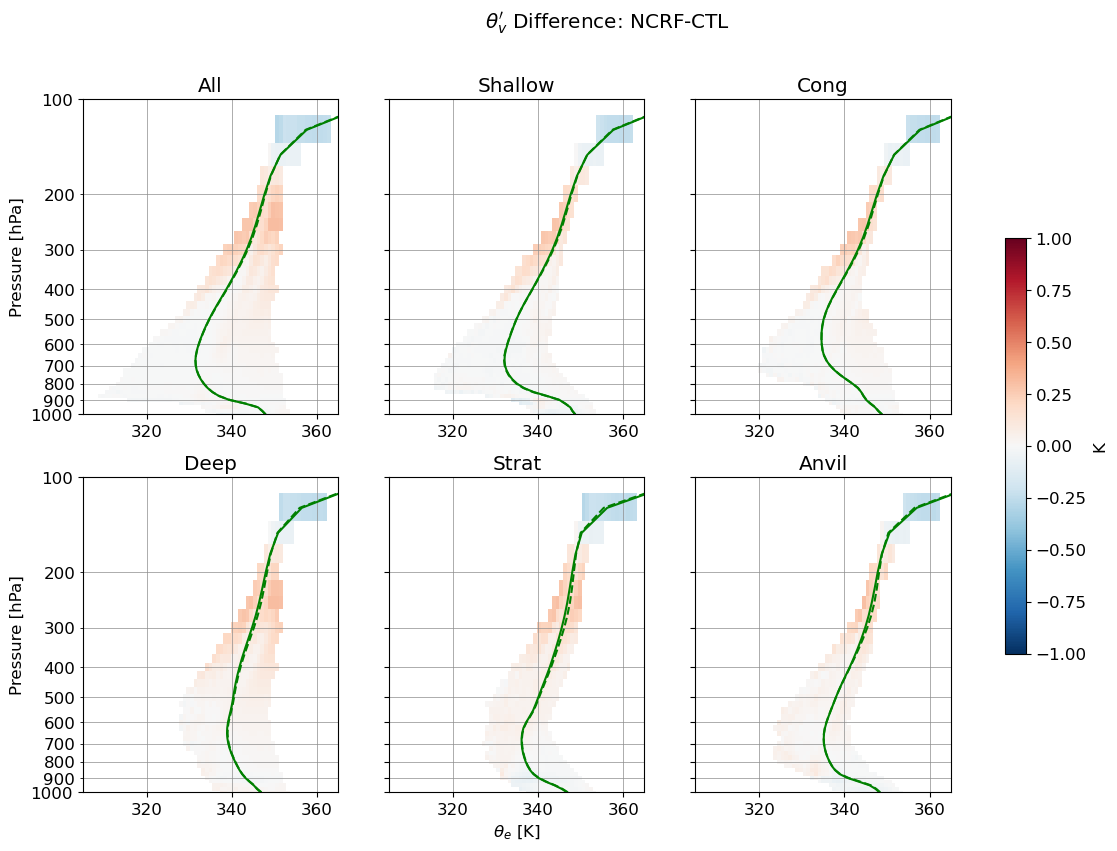

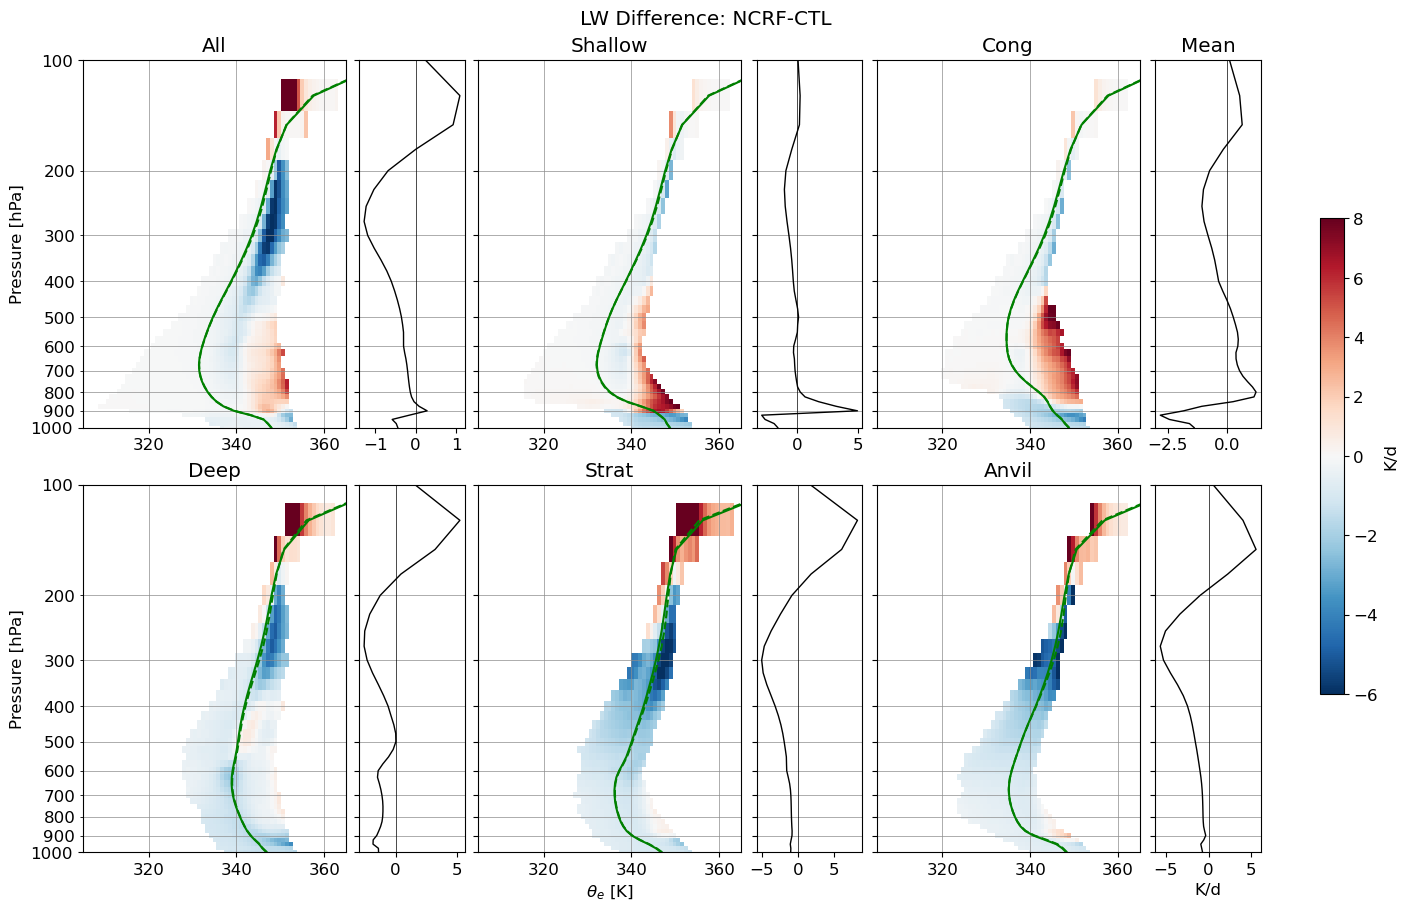

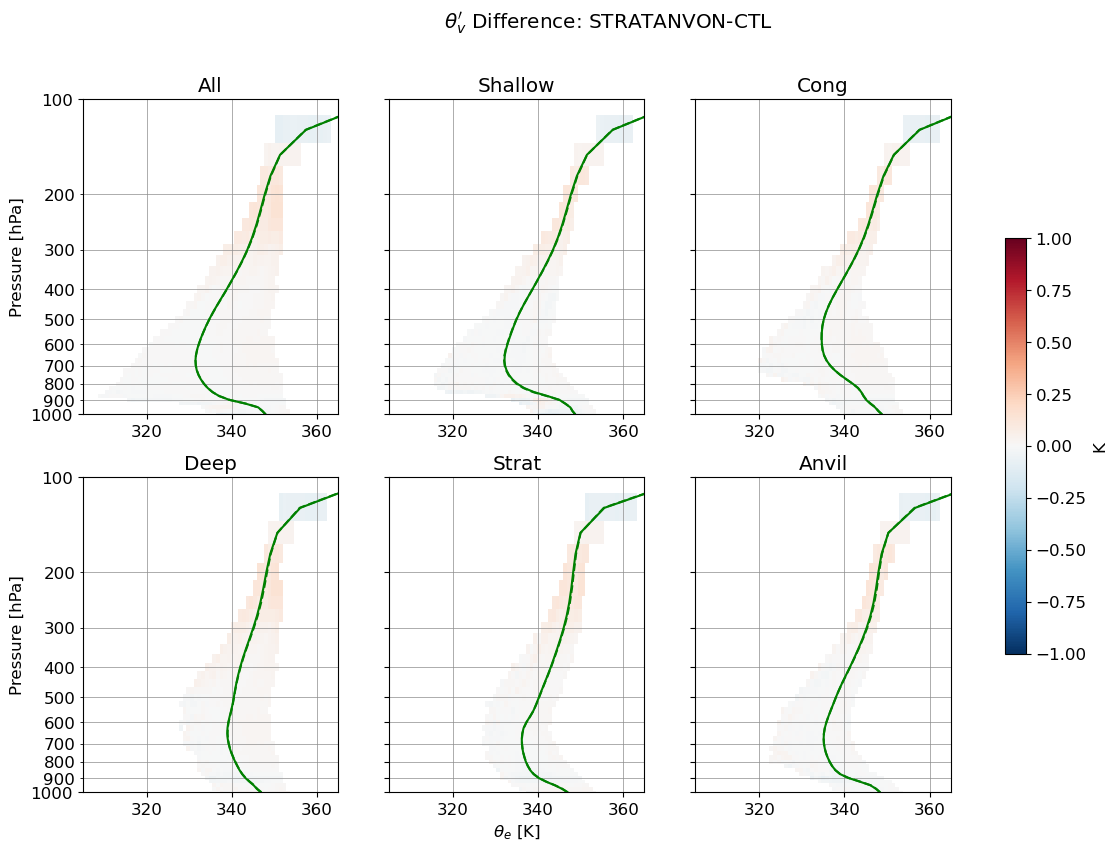

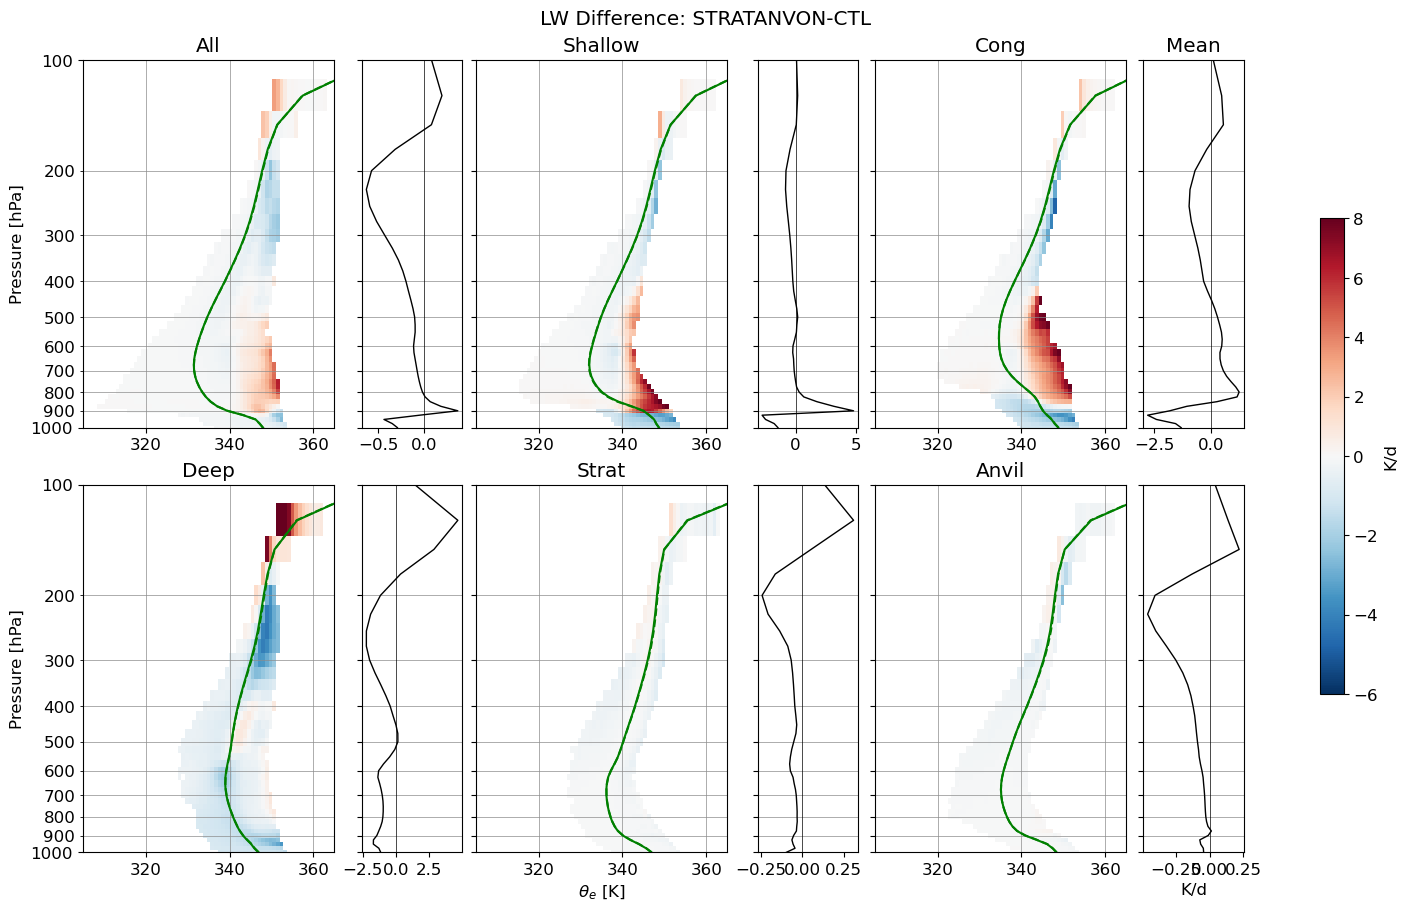

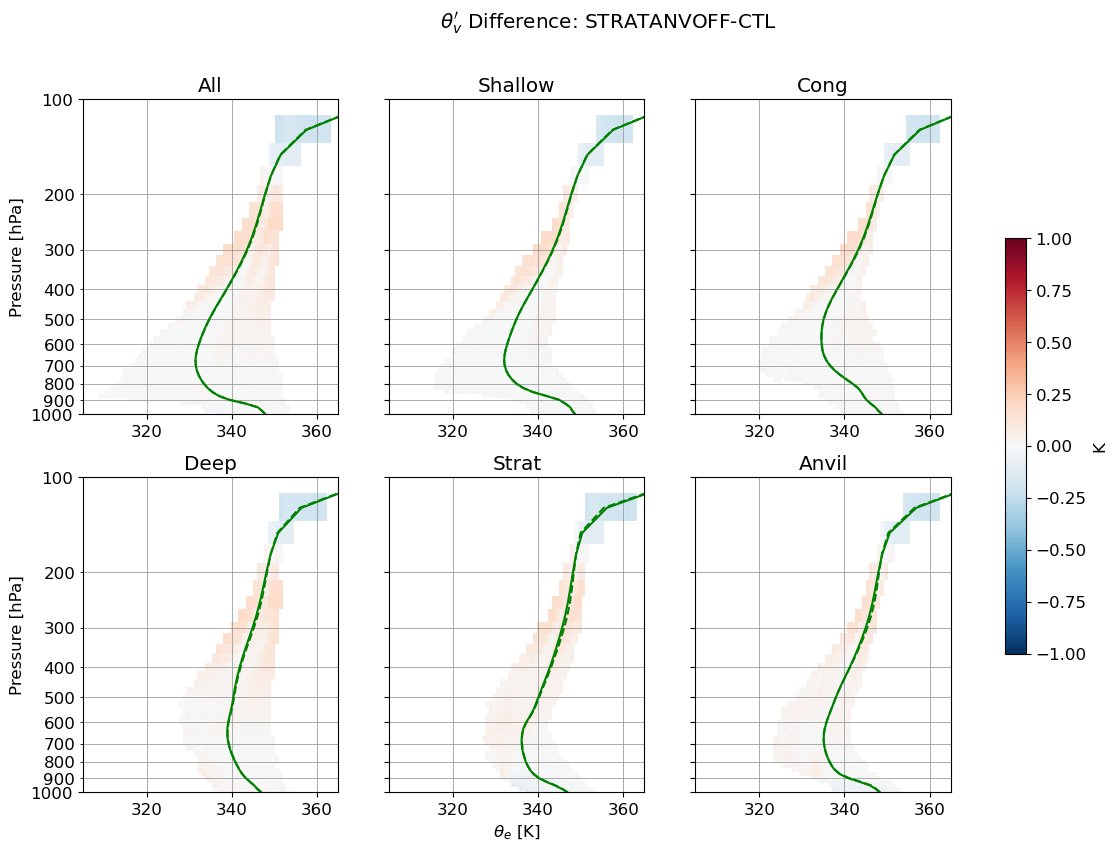

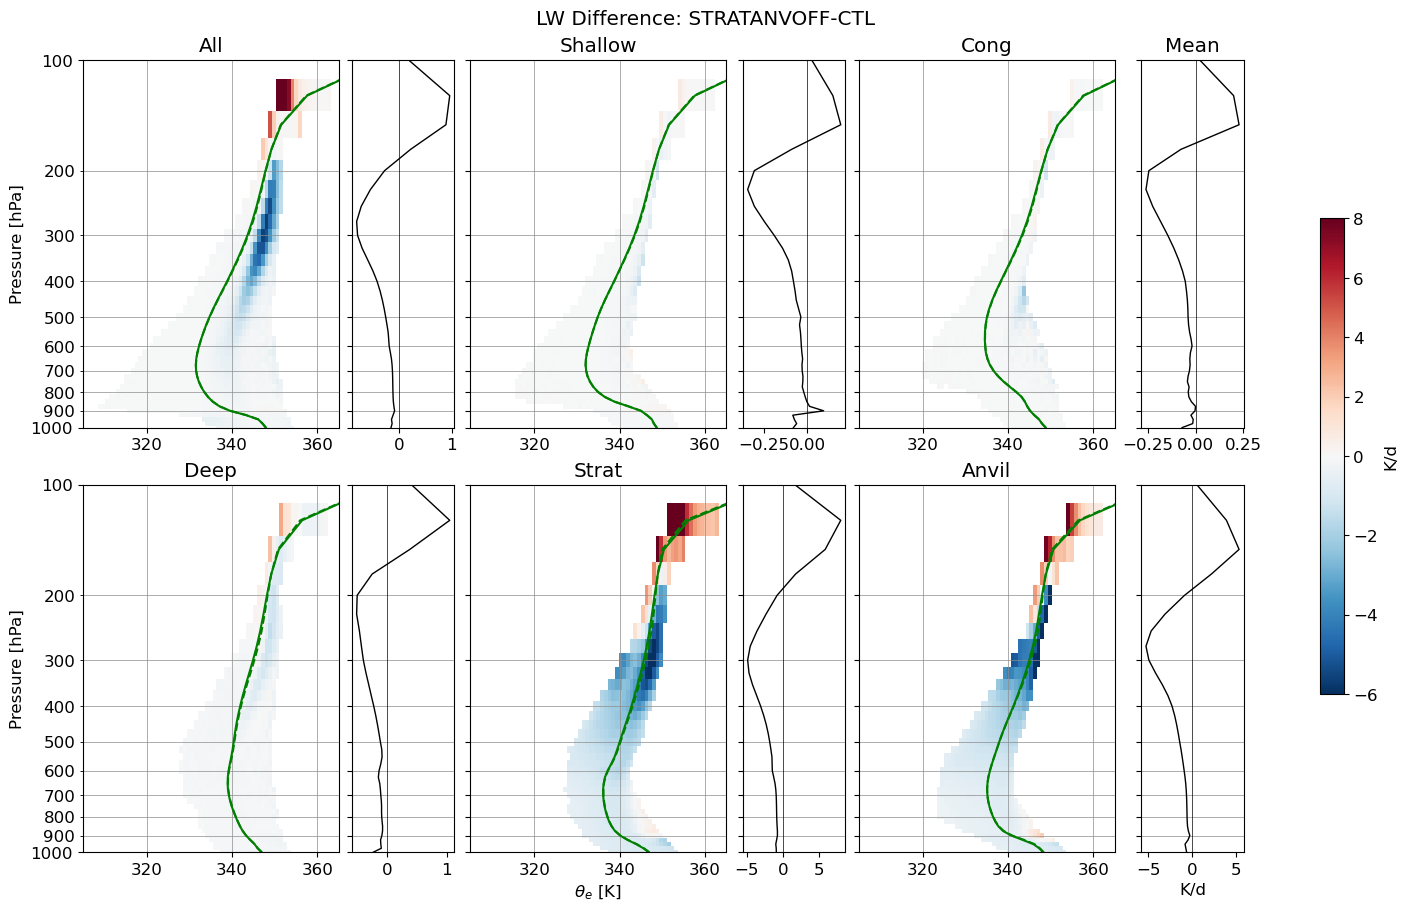

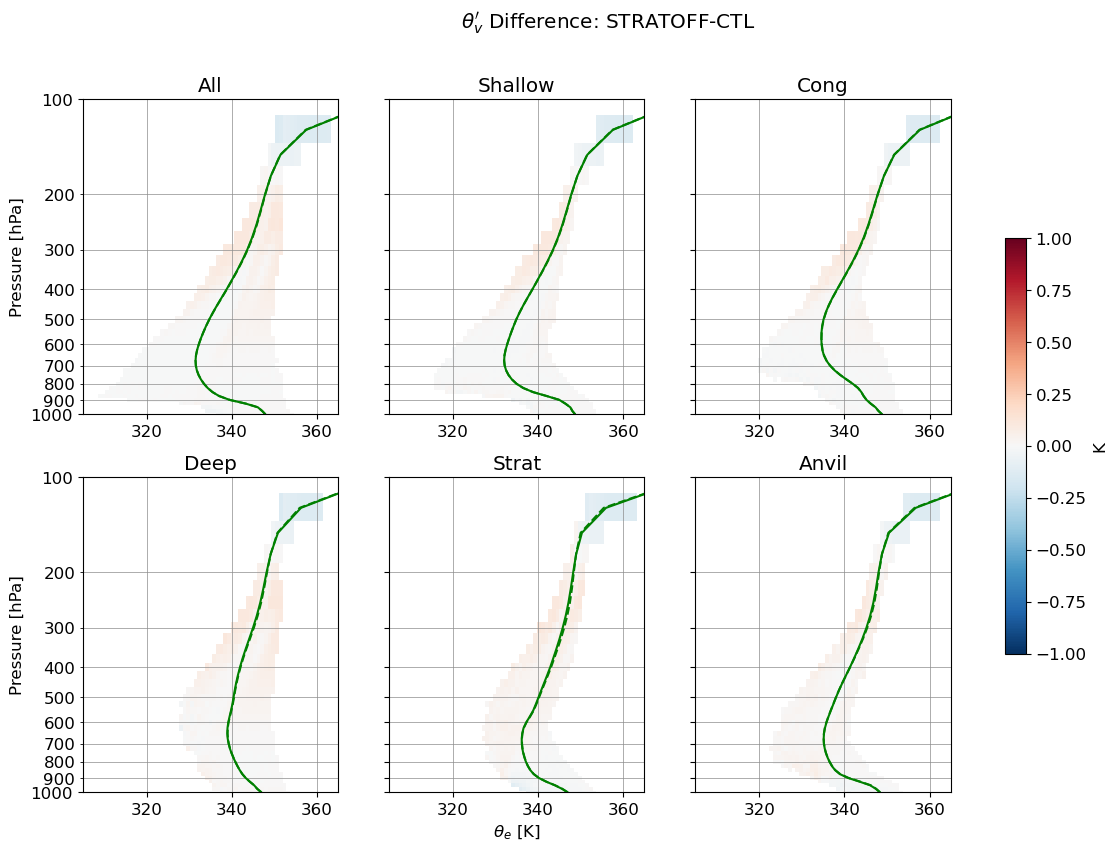

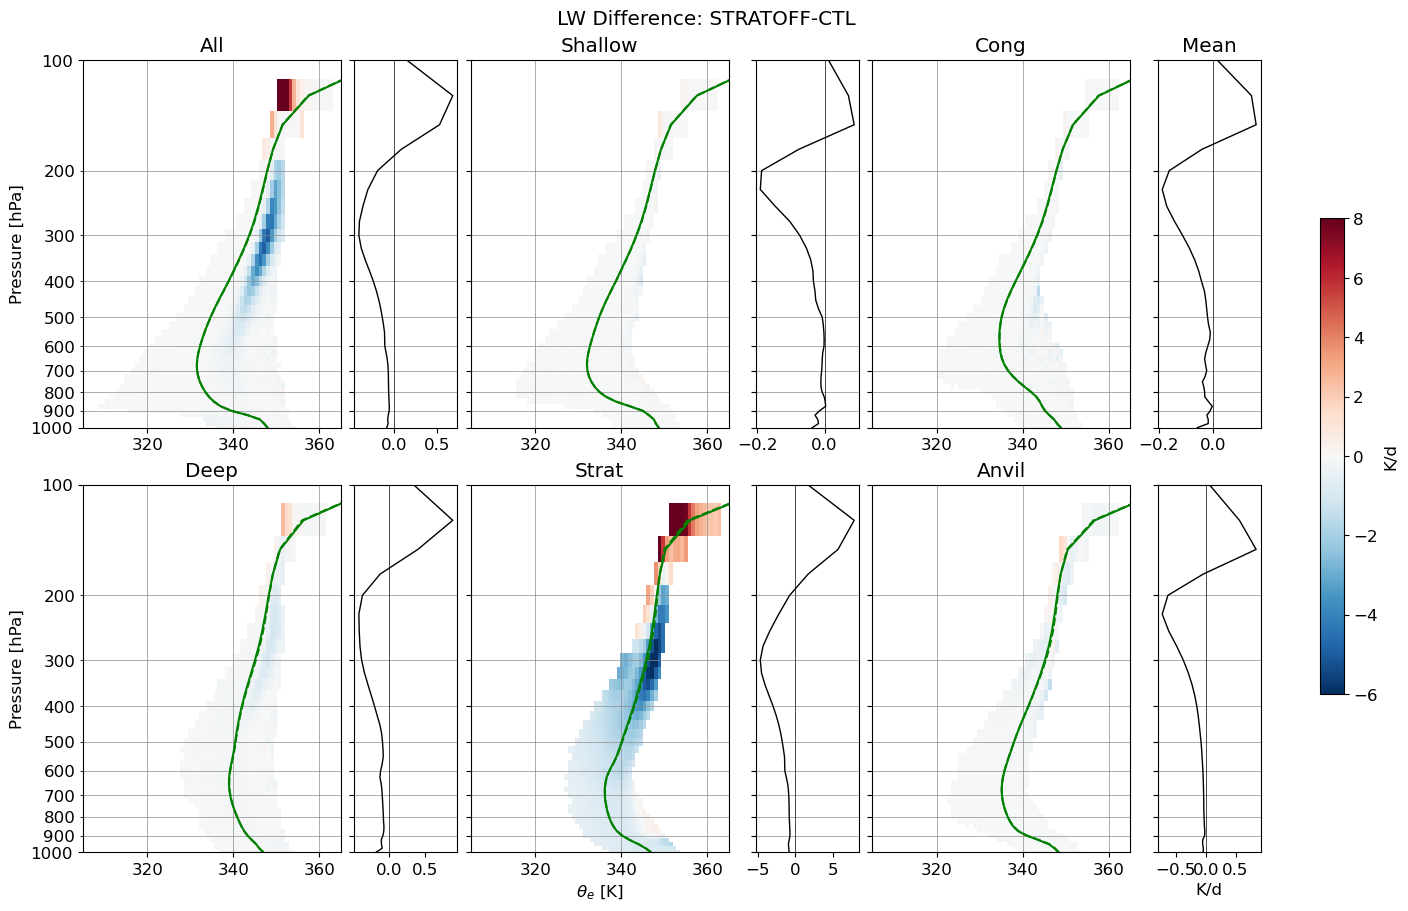

In [22]:
# run_ctl_plots(
#     do_freq=True,
#     do_freqnorm=True,
#     # do_relhum=True,
#     do_vmf=True,
#     do_umf=True,
#     do_dmf=True,
#     # do_lwcrf=True,
#     # do_swcrf=True,
#     # do_swrad=True,
#     # do_totrad=True,
#     # do_thv=True,
#     # do_thvprm=True,
#     )

if not do_tests:

    run_ctl_plots(
        do_freq=True,
        do_freqnorm=True,
        do_relhum=True,
        do_vmf=True,
        do_umf=True,
        do_dmf=True,
        do_lwcrf=True,
        do_swcrf=True,
        do_swrad=True,
        do_totrad=True,
        do_thv=True,
        do_thvprm=True,
        )

elif do_tests:

    run_testdiff_plots(
        # do_freq=True,
        # do_relhum=True,
        # do_vmf=True,
        # do_vmf_norm=True,
        # do_umf=True,
        # do_dmf=True,
        do_lw=True,
        # do_thv=True,
        do_thvprm=True,
        )

### GMS check

In [12]:
# print(dse.shape)
# ip=0
# ix=34
# for iz in range(nz):
#     # print(z[iz]/1e3,'   ',rho[4,ip,4,iz,ix], '   ', dse[ip,iz,ix]/1e4)
#     # print(z[iz]/1e3,'   ',rho_mnn[iz], '   ', dse[ip,iz,ix]/1e4)
#     # print(z[iz]/1e3,'   ',dsdp[ip,iz,ix], '   ', dse[ip,iz,ix]/1e4)
#     # print(z[iz]/1e3,'   ',lv*dqdp[ip,iz,ix], '   ', qv_mean[ip,iz,ix]*1e3)
#     print(z[iz]/1e3,'   ',chik[ip,iz,ix], '   ', qv_mean[ip,iz,ix]*1e3)

In [13]:
# do_gms = True
do_gms = False

if do_gms:

    ktest0=0

    cp=1004 # J/K/kg
    g=9.81
    ig = 1/g

    qv = np.array(allvars['qv'][ktest0])
    qv_mean = np.mean(qv,axis=(0,2))
    tmpk = np.array(allvars['tmpk'][ktest0])
    tmpk_mean = np.mean(tmpk,axis=(0,2))
    rho = np.array(allvars['rho'][ktest0])
    # rho_mean = np.mean(tmpk,axis=(0,2))
    th_mean0 = np.array(allvars['theta_e_mn'][ktest0])
    th_mean0 = np.mean(th_mean0,axis=(0,2))

    # Get height
    # dp/dz = -rho*g  -->  z = -1/g * int(rho*dp)
    dp = (pres[1]-pres[0])*1e2
    rho_mnn = np.nanmean(rho,axis=(0,1,2,4))
    z=np.zeros(nz)
    for iz in range(1,nz):
        z[iz] = z[iz-1] - dp/(g*rho_mnn[iz])

    dse = cp*tmpk_mean + g*z[np.newaxis,:,np.newaxis]

    # Calculate Chikira parameter
    dsdp = np.gradient(dse, dp, axis=1)
    dqdp = np.gradient(qv_mean, dp, axis=1)
    lv = 2.5e6 # J/kg
    chik0 = -lv*(dqdp/dsdp)
    # chik_mn = np.nanmean(chik)
    # chik -= chik_mn

    title_tag = "DSE' ("+tests_str[ktest0].upper()+')  '
    units = 'J/kg'
    cmap = 'RdGy_r'
    # normmin=-1e0; normmax=1e0
    # norm = colors.SymLogNorm(linthresh=1e-2, linscale=1, vmin=normmin, vmax=normmax)
    # plot_pclass_multipan(bins, pres, dse/1e4, th_mean, title_tag, units, pclass_title,
    #                     cmap=cmap, norm=None)#, invar_mean=invar_allmean)

    title_tag = r"$\alpha$ ("+tests_str[ktest0].upper()+')  '
    units = 'unitless'
    cmap = 'RdGy_r'
    normmin=0; normmax=2
    norm = colors.Normalize(vmin=normmin, vmax=normmax)
    # norm = colors.CenteredNorm(halfrange=0.25)
    plot_pclass_multipan(bins, pres, chik0, th_mean0, title_tag, units, pclass_title,
                        cmap=cmap, norm=norm)#, invar_mean=invar_allmean)


In [14]:
if do_gms:

    # for ktest in range(1,ntest):
    for ktest in range(1,2):

        qv = np.array(allvars['qv'][ktest])
        tmpk = np.array(allvars['tmpk'][ktest])
        qv_mean = np.mean(qv,axis=(0,2))
        tmpk_mean = np.mean(tmpk,axis=(0,2))
        th_mean1 = np.array(allvars['theta_e_mn'][ktest])
        th_mean1 = np.mean(th_mean1,axis=(0,2))

        dse = cp*tmpk_mean + g*z[np.newaxis,:,np.newaxis]
        dsdp = np.gradient(dse, dp, axis=1)
        dqdp = np.gradient(qv_mean, dp, axis=1)
        chik1 = -lv*(dqdp/dsdp)
        # chik_mn = np.nanmean(chik)
        # chik1 -= chik_mn

        title_tag = r"$\alpha$ Difference: "+tests_str[ktest].upper()+'-'+tests_str[ktest0].upper()
        units = '-'
        cmap = 'RdGy_r'
        # norm=None
        norm = colors.CenteredNorm(halfrange=0.01)

        var_diff = chik1 - chik0
        # invar_allmean = thv_allmean1 - thv_allmean0

        plot_pclass_multipan(bins, pres, var_diff, th_mean1, title_tag, units, pclass_title,
                            cmap=cmap, norm=norm, th_mean0=th_mean0)#, do_thm0_pclass=True, invar_mean=invar_allmean)
